# **Getting Started**
In this project, the goal is to predict which passengers survived the tragedy of the sinking of Titanic.
Let's start by importing the necessary modules and importing data:

In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from __future__ import division
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


In [47]:
train_df = pd.read_csv('../input/train.csv')
train_df.shape

(891, 12)

In [48]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [49]:
test_df = pd.read_csv('../input/test.csv')
test_df.shape

(418, 11)

In [50]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# **Pre-processing**

## **Title Extraction from Passenger Names**

Each row of data already has a unique identifier (PassengerId). I have preprocessed the Name column to extract the passenger title from the text data in the Name column. The extracted titles can act as another feature in the model

In [51]:
#process name column to extract passenger titles
#training data
name_col = train_df['Name']
titles_ls = []
for name in name_col:
    title = name.split(', ')[1].split('. ')[0]
    titles_ls.append(title)
list(set(titles_ls)) #get the unique titles

['Dr',
 'Master',
 'Mlle',
 'Ms',
 'Mrs',
 'Major',
 'Mr',
 'Sir',
 'Capt',
 'Miss',
 'Jonkheer',
 'Mme',
 'Col',
 'Lady',
 'Rev',
 'Don',
 'the Countess']

It would help the generalizability of the model to have broader categories as far as the different title categories go. So, next, I manually narrowed down the titles to the following:

In [52]:
title_mapper = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Dr":         "Officer",
    "Rev":        "Officer",    
    "Jonkheer":   "Upper_Class",
    "Don":        "Upper_Class",
    "Sir" :       "Upper_Class",
    "Lady" :      "Upper_Class",    
    "the Countess":"Upper_Class",
    "Dona":       "Upper_Class",    
    "Mlle":       "Miss",
    "Miss" :      "Miss",
    "Mme":        "Mrs",    
    "Ms":         "Mrs",
    "Mrs" :       "Mrs",    
    "Master" :    "Master",
    "Mr" :        "Mr"    
}

Add Title column to data:

In [53]:
title_col = []
for title in titles_ls:
    title_col.append(title_mapper[title])
train_df['Title'] = title_col  
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Before we add the Title column to test data, we need to make sure that we will not face any unseen titles (i.e. absent keys in the mapper):

In [54]:
#test data
name_col = test_df['Name']
titles_ls = []
for name in name_col:
    title = name.split(', ')[1].split('. ')[0]
    titles_ls.append(title)
list(set(titles_ls)) #get the unique titles

['Dr', 'Master', 'Ms', 'Mrs', 'Mr', 'Miss', 'Col', 'Dona', 'Rev']

Okay there are no new titles in the test set. With that being confirmed, let's add the feature to the test set as well

In [55]:
title_col = []
for title in titles_ls:
    title_col.append(title_mapper[title])
test_df['Title'] = title_col  
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


Now that the feature Title has been successfully created, we can go ahead and remove the Name column:

In [56]:
train_df.drop('Name', axis=1, inplace=True)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [57]:
test_df.drop('Name', axis=1, inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [58]:
passengerId = test_df['PassengerId']

In [59]:
train_df.drop('PassengerId', axis=1, inplace=True)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [60]:
test_df.drop('PassengerId', axis=1, inplace=True)
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,3,female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,2,male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,3,male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,3,female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


## **Handling Missing Values**

As the quick scanning of the dataset hints, there are columns in both train and test data that contain missing values. Let's look closer to the data for possible missing values and go about handling these missing entries in the data:

In [61]:
#print number of missing entries in each column of the training data
train_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Title         0
dtype: int64

In [62]:
#detect which columns include NaN's in the training data
nan_col_train = train_df.columns[train_df.isna().any()].tolist() #train data
nan_col_train

['Age', 'Cabin', 'Embarked']

In [63]:
#print number of missing entries in each column of the test data
test_df.isnull().sum()

Pclass        0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
Title         0
dtype: int64

In [64]:
#detect which columns include NaN's in the test dataset
nan_col_test = test_df.columns[test_df.isna().any()].tolist() #test data
nan_col_test

['Age', 'Fare', 'Cabin']

As indicated above, each of the training and test dataset has three columns that include at least one NaN value. We can also take a look at the percentage of the missing entries for each of these features:

In [65]:
#train data
for col in nan_col_train:
    col_data = train_df[col]
    null_entry_cnt = col_data.isnull().sum()
    #print(null_entry_cnt)    
    total_entry_cnt = len(col_data)
    nul_ratio = float(null_entry_cnt)/float(total_entry_cnt)
    print("For the training set, %.2f percent of data in the column %s is missing entries" \
          % (100*nul_ratio, col))
# test data
for col in nan_col_test:
    col_data = test_df[col]
    null_entry_cnt = col_data.isnull().sum()
    #print(null_entry_cnt)
    total_entry_cnt = len(col_data)
    nul_ratio = float(null_entry_cnt)/float(total_entry_cnt)
    print("For the test set, %.2f percent of data in the column %s is missing entries" \
          % (100*nul_ratio, col))

For the training set, 19.87 percent of data in the column Age is missing entries
For the training set, 77.10 percent of data in the column Cabin is missing entries
For the training set, 0.22 percent of data in the column Embarked is missing entries
For the test set, 20.57 percent of data in the column Age is missing entries
For the test set, 0.24 percent of data in the column Fare is missing entries
For the test set, 78.23 percent of data in the column Cabin is missing entries


I have used imputation to handle the missing values:

In [66]:
imp_const = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value="unk")
imp_const.fit(train_df[['Cabin']])

SimpleImputer(copy=True, fill_value='unk', missing_values=nan,
       strategy='constant', verbose=0)

In [67]:
train_df['Cabin'].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

In [68]:
train_df['Cabin'] = imp_const.transform(train_df[['Cabin']]).ravel()

In [69]:
train_df['Cabin'].head(10)

0     unk
1     C85
2     unk
3    C123
4     unk
5     unk
6     E46
7     unk
8     unk
9     unk
Name: Cabin, dtype: object

For the column "Cabin", since the percentage of missing values is very big, I used the constant imputation method to replace all the NaN's with string "unk". Let's use the fitted imputer to transform the test set as well:

In [70]:
test_df['Cabin'] = imp_const.transform(test_df[['Cabin']]).ravel()
test_df['Cabin'].head(10)

0    unk
1    unk
2    unk
3    unk
4    unk
5    unk
6    unk
7    unk
8    unk
9    unk
Name: Cabin, dtype: object

For Age and Fare, use median of the existing values for imputation:

In [71]:
imp_median_age = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median_age.fit(train_df[['Age']])

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [72]:
train_df['Age'] = imp_median_age.transform(train_df[['Age']]).ravel()

In [73]:
test_df['Age'] = imp_median_age.transform(test_df[['Age']]).ravel()

In [74]:
imp_median_fare = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median_fare.fit(train_df[['Fare']])

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [75]:
test_df['Fare'] = imp_median_fare.transform(test_df[['Fare']]).ravel()

In [76]:
imp_frequent = SimpleImputer(strategy='most_frequent')
imp_frequent.fit(train_df[['Embarked']])

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)

In [77]:
train_df['Embarked'] = imp_frequent.transform(train_df[['Embarked']]).ravel()

## **Handling Categorical Features**

Now, let's perform one-hot encoding on categorical features. For that, we would first need to detect which column(s) represent categorical variables:

In [78]:
# categorical variables in training data
all_col = train_df.columns
num_cols = train_df._get_numeric_data().columns
cat_cols_train = list(set(all_col) - set(num_cols))
# categorical variables in test data
all_col = test_df.columns
num_cols = test_df._get_numeric_data().columns
cat_cols_test = list(set(all_col) - set(num_cols))

In [79]:
cat_cols = list(set(cat_cols_train + cat_cols_test))
cat_cols

['Embarked', 'Cabin', 'Title', 'Ticket', 'Sex']

In [80]:
#train = pd.get_dummies(train_df, columns=cat_cols)
#test = pd.get_dummies(test_df, columns=cat_cols)
len_train = train_df.shape[0]
train_test_df = pd.concat([train_df, test_df])
X_train_test_ohe = pd.get_dummies(train_test_df, columns=cat_cols)

# Separate them again into train and test
train_df, test_df = X_train_test_ohe.iloc[:len_train, :], X_train_test_ohe.iloc[len_train:, :]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


Now let's further process train data to extract the labels:

In [81]:
y_train_col = train_df.Survived 
y_train = y_train_col.values
x_train_df = train_df.drop(['Survived'], axis=1)
x_train = x_train_df.values

In [82]:
x_train.shape

(891, 1132)

In [83]:
y_train.shape

(891,)

In [84]:
# drop the label column in test data
x_test_df = test_df.drop(['Survived'], axis=1)
x_test = x_test_df.values
x_test.shape

(418, 1132)

To get more insight into the data, let's take a look at the training labels to get a sense of the relative population of the two classes ("survived" vs. "not-survived")

In [85]:
label_map = {}
label_map = {1: "survived", 0: "deceased"} #map label to survival status for visualization purposes
label_map

{1: 'survived', 0: 'deceased'}

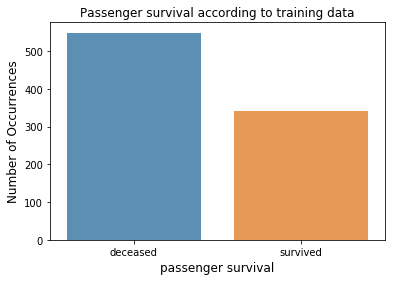

In [86]:
passngr_cnt  = y_train_col.value_counts()
passngr_idx = passngr_cnt.index
plt_idx = [label_map[idx] for idx in passngr_idx]    
plt.figure()
sns.barplot(plt_idx, passngr_cnt.values, alpha=0.8)
plt.title('Passenger survival according to training data')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('passenger survival', fontsize=12)
plt.show()

## **Feature Scaling**

Let's standardize the features before fitting our model:

In [87]:
#perform feature standardization
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train) 
x_test = scaler.transform(x_test)

## **Classification**

For my classification model, I have used Random Forest classifier from Scikit-learn. I performed hyperparameter tuning via cross validation as below:

In [88]:
# Random Forest
clf = RandomForestClassifier(random_state=0)
param_grid = {'n_estimators': [5, 10, 15, 20, 25, 50],
              'max_depth': [2, 5, 7, 10],
              'max_features': [250, 300, 400, 500],
              'min_samples_leaf': [5, 10, 50]
             }
#'min_samples_leaf': [2, 3, 4, 5]
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                        cv=5, scoring ='accuracy')
grid_search.fit(x_train, y_train)

grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=500, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [89]:
preds = [int(pred) for pred in grid_search.predict(x_test)]
result = pd.DataFrame({'PassengerId': passengerId, 'Survived': preds})
# save to csv
result.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [90]:
fname = 'Titanic_randomforest_7.csv'
result.to_csv(fname,index=False)